In [2]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
# Load datasets
file = 'datasets/credit_card_data/cc.csv'
data = pd.read_csv(file)

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)

In [4]:
data.shape

(284807, 31)

In [5]:
# fraud
data.Class.sum() / data.shape[0]

0.001727485630620034

In [6]:
# Define evaluation functions

In [7]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [8]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [9]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

In [47]:
def print_stats(preds):
    preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
    cutoff = preds.trueLabel.sum()
    predsTop = preds[:cutoff]
    # out of everything i said was fraud, how much is actually fraud
    print("Precision: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
    # out of everything that is fraud, how much did i catch
    print("Recall: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
    print("Fraud Caught out of", cutoff, "Cases:", 
          predsTop.trueLabel.sum(), 
          "Percentage caught:", 
          predsTop.trueLabel.sum() / cutoff)

In [48]:
# PCA

In [49]:
# 30 principal components
from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

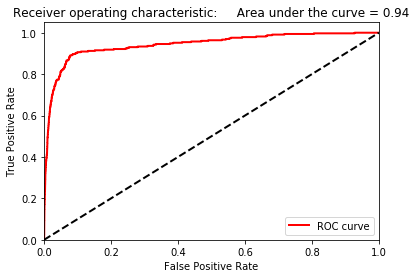

In [50]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [51]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
preds[:10]

trueLabel  anomalyScore
142087          0      1.000000
277038          0      0.835157
165168          0      0.811954
17709           0      0.519947
274771          0      0.516306
148255          0      0.430174
39769           0      0.380836
235908          0      0.354272
228711          0      0.270816
135075          0      0.251910

In [52]:
print_stats(preds)

Precision:  0.17
Recall:  0.17
Fraud Caught out of 330 Cases: 55 Percentage caught: 0.16666666666666666


In [25]:
# p = tp / tp + fp
# r = tp / tp + fn

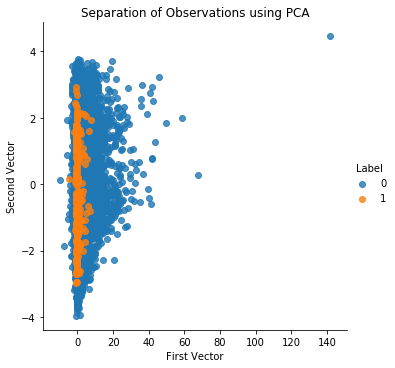

In [26]:
# 27 principal components
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

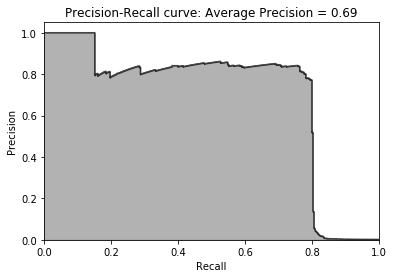

In [27]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [28]:
print_stats(preds)

Precision:  0.78
Recall:  0.78
Fraud Caught out of 350 Cases: 258 Percentage caught: 0.7818181818181819


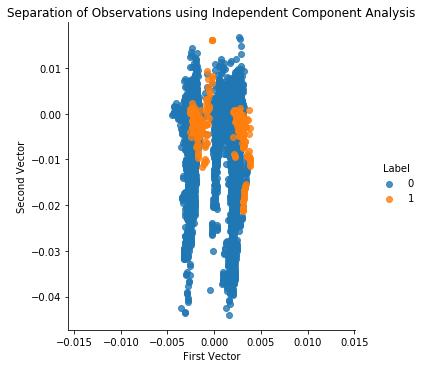

In [29]:
# Independent Component Analysis

from sklearn.decomposition import FastICA

n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2018

fastICA = FastICA(n_components=n_components, \
    algorithm=algorithm, whiten=whiten, max_iter=max_iter, \
    random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=X_train.index)

X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, \
                                       index=X_train.index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

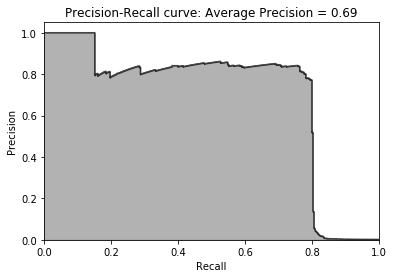

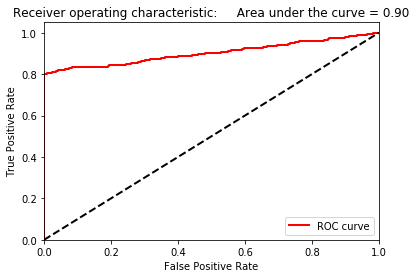

In [30]:
anomalyScoresFastICA = anomalyScores(X_train, X_train_fastICA_inverse)
preds = plotResults(y_train, anomalyScoresFastICA, True)

In [31]:
print_stats(preds)

Precision:  0.78
Recall:  0.78
Fraud Caught out of 350 Cases: 258 Percentage caught: 0.7818181818181819


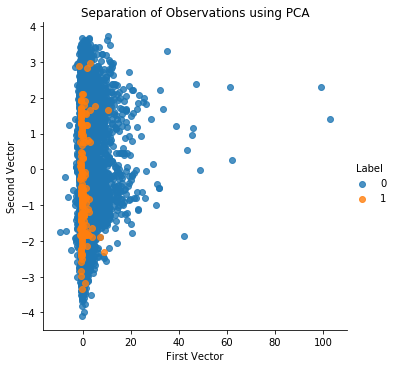

In [32]:
# PCA on Test Set
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, \
                                  index=X_test.index)

scatterPlot(X_test_PCA, y_test, "PCA")

In [33]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

In [34]:
print_stats(preds)

Precision:  0.79
Recall:  0.39
Fraud Caught out of 350 Cases: 128 Percentage caught: 0.7901234567901234


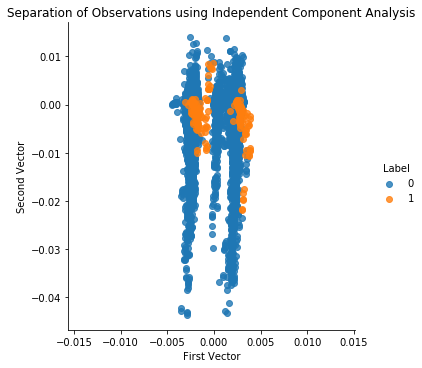

In [35]:
# Independent Component Analysis on Test Set
X_test_fastICA = fastICA.transform(X_test)
X_test_fastICA = pd.DataFrame(data=X_test_fastICA, index=X_test.index)

X_test_fastICA_inverse = fastICA.inverse_transform(X_test_fastICA)
X_test_fastICA_inverse = pd.DataFrame(data=X_test_fastICA_inverse, \
                                      index=X_test.index)

scatterPlot(X_test_fastICA, y_test, "Independent Component Analysis")

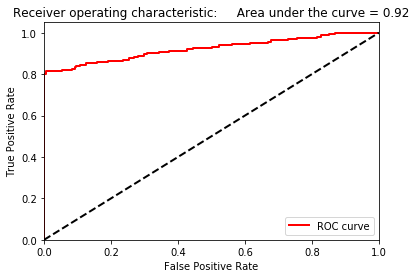

In [36]:
anomalyScoresFastICA = anomalyScores(X_test, X_test_fastICA_inverse)
preds = plotResults(y_test, anomalyScoresFastICA, True)

In [37]:
print_stats(preds)

Precision:  0.79
Recall:  0.39
Fraud Caught out of 350 Cases: 128 Percentage caught: 0.7901234567901234


In [43]:
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train); rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
pd.Series(rfc.predict(X_test)).value_counts()

0    93846
1      141
dtype: int64

In [45]:
recall_score(y_test, rfc.predict(X_test))

0.8148148148148148

In [46]:
precision_score(y_test, rfc.predict(X_test))

0.9361702127659575